In [1]:
# load ~32000 names from a file, one in each line
with open("names.txt", "r") as infile:
    words = infile.read().splitlines() # ignores \n

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# create a dictionary with keys as bigrams and values as numbers of their occurrences
bigram_n = {}
for w in words:
    chars = ["."] + list(w) + ["."] # special start/end character
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = ch1 + ch2
        bigram_n[bigram] = bigram_n.get(bigram, 0) + 1 # returns 0 if the key is not found

In [5]:
sorted(bigram_n.items(), key=lambda kv: -kv[1])[:10]

[('n.', 6763),
 ('a.', 6640),
 ('an', 5438),
 ('.a', 4410),
 ('e.', 3983),
 ('ar', 3264),
 ('el', 3248),
 ('ri', 3033),
 ('na', 2977),
 ('.k', 2963)]

In [6]:
# ---------------- tensor instead of a dictionary ----------------

In [7]:
chars = sorted(set("".join(words)))

In [8]:
ctoi = {s: i+1 for i, s in enumerate(chars)}
ctoi["."] = 0

In [9]:
itoc = {i: s for s, i in ctoi.items()}

In [10]:
# actually, it will be more convenient to keep these values in a 2D array (tensor/matrix)
import torch

In [48]:
N = torch.zeros((27, 27), dtype=torch.int32) # 26 letters + the special character

In [61]:
# create a 2D array with each cell corresponding to a particular bigram and its value being the number of occurrences
for w in words:
    chars = ["."] + list(w) + ["."] # special start/end character
    for ch1, ch2 in zip(chars, chars[1:]):
        idx1 = ctoi[ch1]
        idx2 = ctoi[ch2]
        N[idx1][idx2] += 1

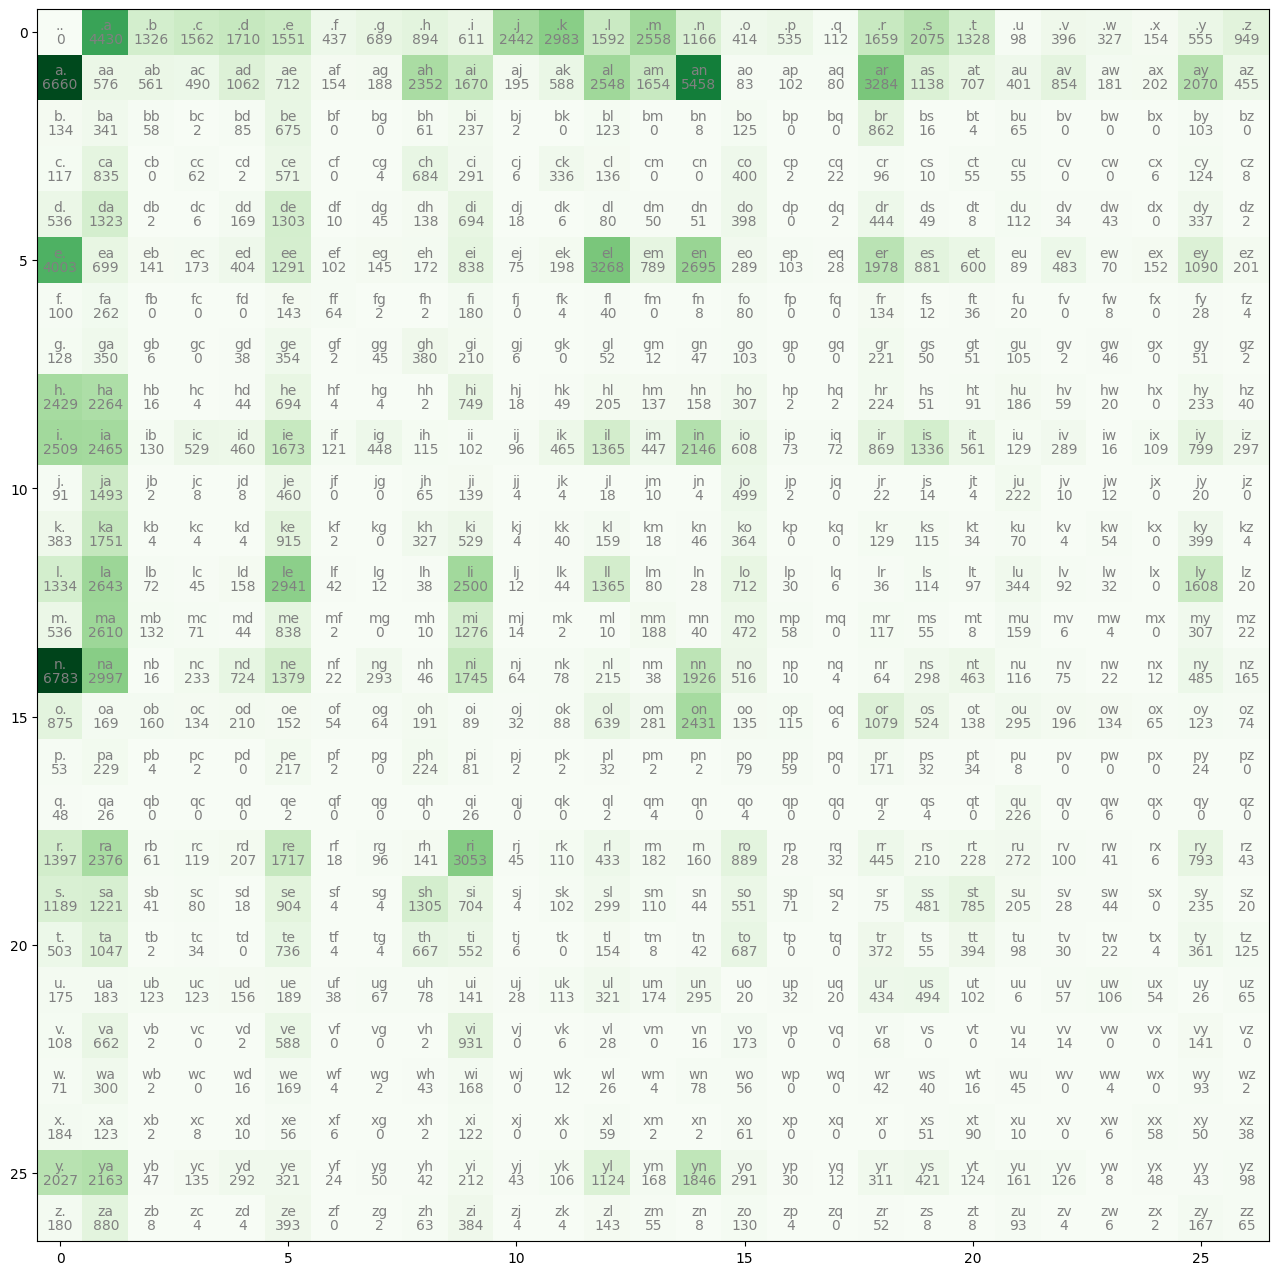

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Greens")

for i in range(27):
    for j in range(27):
        bigram_txt = itoc[i] + itoc[j]
        plt.text(j, i, bigram_txt, va="bottom", ha="center", c="gray")
        plt.text(j, i, N[i, j].item(), va="top", ha="center", c="gray")

In [64]:
N[0] # raw counts

tensor([   0, 4430, 1326, 1562, 1710, 1551,  437,  689,  894,  611, 2442, 2983,
        1592, 2558, 1166,  414,  535,  112, 1659, 2075, 1328,   98,  396,  327,
         154,  555,  949], dtype=torch.int32)

In [65]:
N[0].shape

torch.Size([27])

In [66]:
p = N[0].float() # probabilitity of a given character to start the word (N[0] is the starting char)
p /= p.sum() # normalize so that we get a distribution
p # sum of that is now 1

tensor([0.0000, 0.1361, 0.0407, 0.0480, 0.0525, 0.0476, 0.0134, 0.0212, 0.0275,
        0.0188, 0.0750, 0.0916, 0.0489, 0.0786, 0.0358, 0.0127, 0.0164, 0.0034,
        0.0510, 0.0637, 0.0408, 0.0030, 0.0122, 0.0100, 0.0047, 0.0170, 0.0292])

In [67]:
gen = torch.Generator().manual_seed(2147483647)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=gen).item() # "convert" probabilities (p) to ints
itoc[idx]

'j'

In [76]:
P = (N+1).float() # +1 for model smoothing (so that if there's no bigram, the cost won't explode to inf)
# 27x27 divided by 27x1
P /= P.sum(1, keepdim=True) # broadcasting, 1 says we want sums of rows (a column vector, 27x1), every P row gets divided by the row sum

In [69]:
# actual sampling!
gen = torch.Generator().manual_seed(2147483647)

idx = 0 # "."
for i in range(20):
    name = []
    while True:
        p = P[idx]
        # p = N[idx].float()
        # p /= p.sum()

        # choose a letter from a row containing bigrams starting with a given letter
        # this row index then becomes index that we use for a column for the next letter
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=gen).item()
        
        name.append(itoc[idx]) # add a letter to the name (1st letter of a bigram)
        if idx == 0: # special "." character
            break
    print("".join(name))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juwe.
ksahnaauranileviasshbdainrwieta.
ssonielylarte.
ffreumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikim.
ynin.
anaasn.
ssorionsush.


In [77]:
# log likelihood
n = 0
log_likelihood = 0.0

for w in words:
# for w in ["szczepan"]:
    chars = ["."] + list(w) + ["."] # special start/end character
    for ch1, ch2 in zip(chars, chars[1:]):
        idx1 = ctoi[ch1]
        idx2 = ctoi[ch2]
        prob = P[idx1][idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        # print(f"{ch1}{ch2} prob: {prob:.4f} logprob: {logprob:.4f}")

nll = -log_likelihood # negative log likelihood
avg_nll = nll / n
avg_nll.item(), n

(2.4575421810150146, 228146)

In [71]:
P[0], P[0].sum()

(tensor([3.0694e-05, 1.3600e-01, 4.0731e-02, 4.7974e-02, 5.2517e-02, 4.7637e-02,
         1.3444e-02, 2.1179e-02, 2.7471e-02, 1.8785e-02, 7.4985e-02, 9.1590e-02,
         4.8895e-02, 7.8545e-02, 3.5820e-02, 1.2738e-02, 1.6452e-02, 3.4684e-03,
         5.0952e-02, 6.3720e-02, 4.0792e-02, 3.0387e-03, 1.2185e-02, 1.0068e-02,
         4.7575e-03, 1.7066e-02, 2.9159e-02]),
 tensor(1.))

In [72]:
torch.log(torch.tensor(0.5))*2, torch.log(torch.tensor(0.4)) + torch.log(torch.tensor(0.6))

(tensor(-1.3863), tensor(-1.4271))